In [3]:
%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = 'device=gpu,compiledir=.gpu'
#os.environ['THEANO_FLAGS'] = 'device=cpu,compiledir=.cpu'

import sys
sys.path.append('..')
import matplotlib.pyplot as plt
from tools.common import disp_grid
from IPython.display import Image
from skimage.io import imsave

from keras.models import model_from_json
import os
import joblib
import numpy as np
from lightjob.cli import load_db
#from skimage.io import imread
from tools.common import find_generation_job, find_training_job, to_generation, compute_sample_objectness, resize_set
from IPython.display import Image, display
from lightjob.cli import load_db
from lightjob.db import SUCCESS
import pandas as pd
import h5py
import cv2

from skimage.transform import resize

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from joblib.parallel import delayed, Parallel
from sklearn.neighbors import NearestNeighbors


def disp_pred(pred, h=20, w=100, y0=25, fontsize=0.9):
    nb_classes = len(pred)
    img = np.zeros((nb_classes * h, w, 3))
    cv2.rectangle(img,(0,0),(img.shape[1],img.shape[0]),(0.3,0.3,0.3),3)
    pad = 0
    col = [[0, 0, 1]] * nb_classes
    for i in range(nb_classes):
        p = int(w * pred[i])
        img[i*(h+pad):i*(h+pad)+h, 0:p, :] = col[i]
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(nb_classes):
        cv2.putText(img,str(i),(10,y0+h*i), font, fontsize,(1,1,1),1,cv2.LINE_AA)
        cv2.rectangle(img,(0, i*(h+pad)),(w, i*(h+pad)+h),(0.3,0.3,0.3),2)

    return img

def disp_grid_with_pred(img, preds, h=30, w=200, y0=25, fontsize=0.9):
    img = resize_set(img, 100, 100)
    img_ = np.zeros((img.shape[0], 3, img.shape[2]*2, img.shape[3]*2))
    img_[:, :, 0:img.shape[2], 0:img.shape[3]] = img[:, :, :, :]
    for i, pr in enumerate(preds):
        text= disp_pred(pr, h=h, w=w, y0=y0, fontsize=fontsize)
        text = resize(text, (img.shape[2], img.shape[3]))
        text = text.transpose((2, 0, 1))
        img_[i, :, 0:img.shape[2], img.shape[3]:] = text
    img_ = disp_grid(img_)
    return img_

from tools.common import resize_set
import shutil
from tools.common import compute_objectness, compute_objectness_renyi, compute_sample_objectness, compute_sample_objectness_renyi
def load_h5(filename):
    f = h5py.File(filename)
    X = f['X']
    nb = f.attrs['nb']
    X = X[0:nb]
    X = np.array(X)
    X = X[np.isnan(X).sum(axis=(1,2,3))==0]
    return X

Using gpu device 0: Tesla K20Xm (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5005)
/home/mcherti/work/code/external/scikit-learn/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


In [152]:
model_folder = '../tools/models/external/fonts_and_digits'
arch = (open(os.path.join(model_folder, 'model.json'))).read()
#arch = arch.replace('softmax', 'linear')
model = model_from_json(arch)
model.load_weights(os.path.join(model_folder, 'model.pkl'))

## checking all generated

In [153]:
#X = load_h5('../exported_data/datasets/jobset83.hdf5')
#X = load_h5('../exported_data/datasets/jobset76.hdf5')

In [167]:
names = ['aa', 'gan']
load_data = [
    #lambda:load_h5('../exported_data/datasets/jobset83.hdf5')[500000:1000000],
    lambda:joblib.load('../jobs/results/517302ec5da070804fd729e9bd44fdc8/images.npz')[:,-1],
    lambda:joblib.load('/home/mcherti/dcgan/jobs/5a91ac06f1c52a41c2d43cb6423404d5/gen.npz')[0:1000]
]



In [168]:
%%time
preds_per_dataset = {}
datasets = {}
for name, d in zip(names, load_data):
    X = d()
    datasets[name] = X
    batch_size = 2048
    preds = []
    for i in range(0, len(X), batch_size):
        x = X[i:i+batch_size]
        preds.append(model.predict(x))
    preds = np.concatenate(preds, axis=0)
    preds_per_dataset[name] = preds

CPU times: user 750 ms, sys: 200 ms, total: 950 ms
Wall time: 956 ms


In [169]:
print(preds_per_dataset['gan'].shape)

(1000, 36)


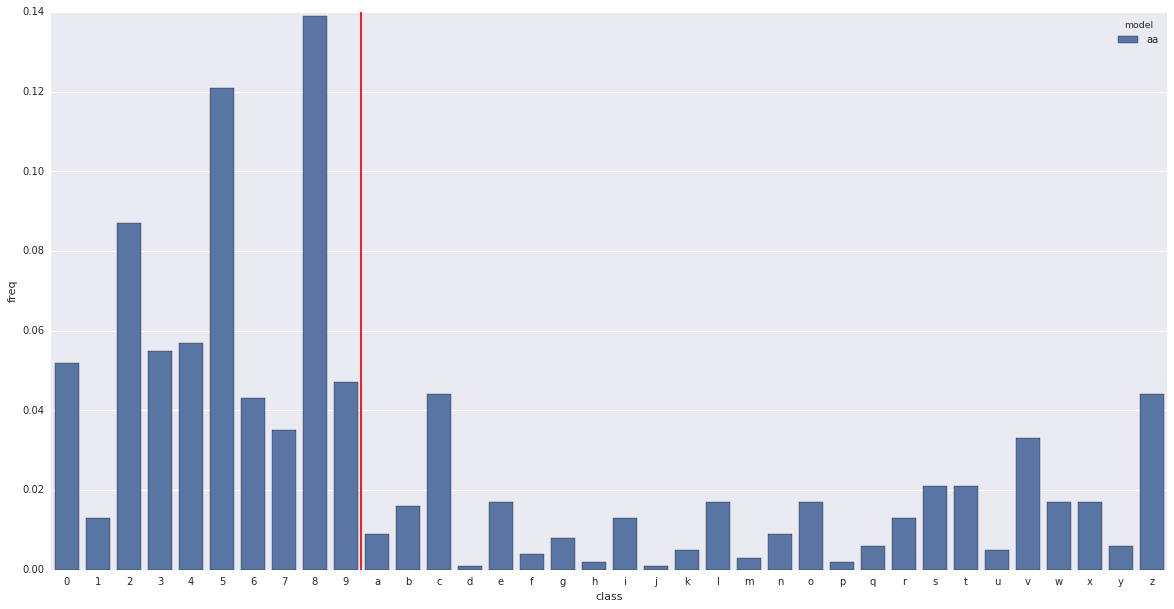

In [170]:
import seaborn as sns
from collections import defaultdict

classes = '0123456789abcdefghijklmnopqrstuvwxyz'

def get_df(p, name):
    df = pd.DataFrame()
    df['argmax'] = map(lambda k:classes[k], p.argmax(axis=1))
    df['argmax_count'] = [1./len(p)] * len(p)
    df['model'] = [name] * len(p)
    return df

df_aa = get_df(preds_per_dataset['aa'], 'aa')
df_gan = get_df(preds_per_dataset['gan'], 'gan')
#df = pd.concat((df_aa, df_gan))
df = df_aa
fig = plt.figure(figsize=(20, 10))
ax = sns.barplot(x="argmax", y="argmax_count", hue='model', data=df, estimator=lambda x:x.sum(), order=classes)
plt.xlabel('class')
plt.ylabel('freq')
plt.axvline(x=9.5, c='red')

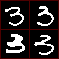

In [171]:
#n = 'abcdefghijklmnopqrstuvwxyz'.index('c')
n = 3
indices = np.arange(len(datasets['aa']))
#indices = indices[compute_objectness(preds)>0.1]
p=preds_per_dataset['aa'][:, n]
indices = indices[np.argsort(p[indices])[::-1]]
#indices = indices[p[indices]>0.5]
img = datasets['aa'][indices]
img = disp_grid(img[0:4], border=1, bordercolor=(0.3, 0, 0))
imsave('imgs/out.png', img)
Image('imgs/out.png')

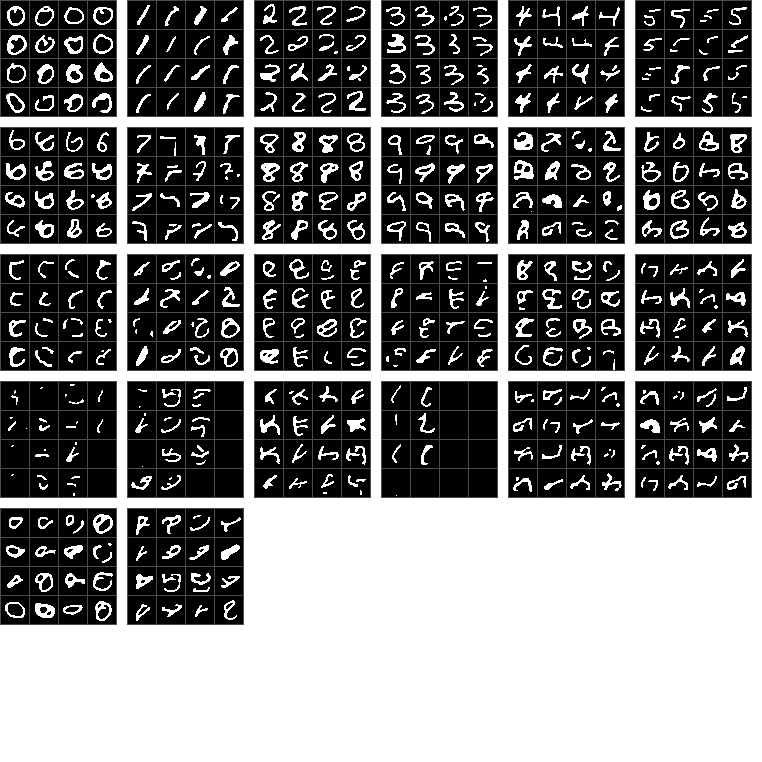

In [187]:
nb_classes = 26
nbrows = 6
nbcols = 6
border = 1
space = 10
scores = {}
SIZE = 4
s = (28+border) * SIZE + border
MODEL = 'aa'
ims = {}
letters = {}
classes = '0123456789abcdefghijklmnopqrstuvwxyz'
img_all = np.ones((nbrows * (s+space), nbcols * (s+space)  ))
for i in range(nbrows):
    for j in range(nbcols):
        indices = np.arange(len(datasets[MODEL]))
        if i*nbcols+j>=nb_classes:
            break
        pr_all = preds_per_dataset[MODEL]
        p=preds_per_dataset[MODEL][:, i*nbcols+j]        
        indices = np.arange(len(datasets[MODEL]))
        indices = indices[np.argsort(p[indices])[::-1]]
        #indices = indices[pr_all[indices][:, 10:].sum(axis=1)>0.95]
        img = datasets[MODEL][indices[0:SIZE*SIZE]]
        scores[i*nbcols+j] = p[indices].copy()
        #print(p[indices][0:16])
        #letters[classes[i*nbcols+j]] = img[np.random.randint(0, 4)]
        #letters[classes[i*nbcols+j]] = img[manual[classes[i*nbcols+j]]]
        letters[classes[i*nbcols+j]] = img[0]
        img = disp_grid(img[0:SIZE*SIZE], border=border, bordercolor=(0.3, 0, 0), shape=(SIZE,SIZE))
        img_all[i*(s+space):i*(s+space) + s, j*(s+space):j*(s+space) + s] = img[:,:,0]
#img_all = 1 - img_all
imsave('imgs/all.png', img_all)
Image('imgs/all.png')

In [189]:

pan = [
    "Pack my box with five dozen liquor jugs".lower(),
    "Jackdaws love my big sphinx of quartz".lower(),
    "The five boxing wizards jump quickly.".lower(),
    "How vexingly quick daft zebras jump".lower(),
    "Bright vixens jump dozy fowl quack".lower(),
    "Sphinx of black quartz, judge my vow".lower(),
]
for s in pan:
    pangram = np.zeros((28 , 28 * len(s)))
    i = 0
    for l in s:
        if l not in letters:
            i += 28
            continue
        pangram[0:28, i:i+28] = letters[l]

        i += 24
    pangram = 1 - pangram
    imsave('out.png', pangram)
    display(Image('out.png'))

## checking stats of jobs

In [ ]:
db = load_db()
jobs = db.jobs_with(state=SUCCESS, where='jobset83')
S = [j['summary'] for j in jobs]
jobs_gen = to_generation(jobs)

In [190]:
k = 'stats.out_of_the_box_classification.fonts.objectness'
jobs_gen = to_generation(jobs)

def sort_by(jobs, k):
    indices = np.arange(len(jobs_gen))
    def key(i):
        val = db.get_value(jobs_gen[i], k, if_not_found=None)
        if val is None or np.isnan(val):
            val = -np.inf
        return val
    indices = sorted(indices, key=key)
    vals = [key(ind) for ind in indices]
    return indices[::-1], vals[::-1]

indices, vals = sort_by(jobs, k)

In [53]:
nb = 20
k1 = 'stats.out_of_the_box_classification.fonts.objectness'
indices, vals = sort_by(jobs, k1)
s1 = [jobs[ind]['summary'] for ind in indices[0:nb]]
k2 = 'stats.out_of_the_box_classification.letterness.diversity_count_letters_99'
indices, vals = sort_by(jobs, k2)
s2 = [jobs[ind]['summary'] for ind in indices[0:nb]]
k3 = 'stats.out_of_the_box_classification.letterness.diversity_max_letters'
indices, vals = sort_by(jobs, k3)
s3 = [jobs[ind]['summary'] for ind in indices[0:nb]]

In [54]:
print(len(set(s1).intersection(set(s2))))

6


In [55]:
#m = list((set(s1).intersection(set(s2)).intersection(set(s3))  ))
m = list(set(s1).intersection(s2))
print(m)

[u'bf163f76cb795fe33aaee7f2f2db136a', u'94d0ef43db9fbcd674207c6cc7803983', u'30b833a0b781f2a4c0f736347956b268', u'c8be08dae7874f162d68dad856f73fcc', u'1b5f929796b52352a009ab37f602bfbf', u'6c761ed85005ba530a636fcc2a751c1d']


In [582]:
I = 8
db.get_job_by_summary(m[I])['content']['model_params'], m[I]

IndexError: list index out of range

In [633]:
from tools.common import find_generation_job

In [636]:
# Intersect on s1 and s2, top 20, AA
summaries = [
    '9c5cc9c315ad13f6e1151200f885d54a',
    'a3a97a790acf41b122a94af93834a301',
    '1b5f929796b52352a009ab37f602bfbf', # used
    '0396380c8787034efd079b32a51d9dd6', #used
    '6c761ed85005ba530a636fcc2a751c1d',#used
]
# 
gen_summ = [
    find_generation_job(s)['summary']
    for s in summaries
]
for s in gen_summ:
    print(s)

34f7060e2642a9074949c7e71504d52b
efe730bdb99d27bee849e0bb406cfad7
517302ec5da070804fd729e9bd44fdc8
e527e0b59433177b40e1a6d3f63dbd45
0701e9403f58d63905f45f38f7e1b466


In [676]:
for s in summaries[2:]:
    print(db.get_job_by_summary(s)['content'])

{u'binarize_thresh': None, u'noise': u'salt_and_pepper', u'budget_hours': 2, u'model_params': {u'nb_hidden_units': [400, 900, 100, 200, 800], u'wta_sparse_perc': 0.05050505050505051, u'nb_layers': 5, u'use_wta_sparse': True}, u'denoise': 0.14141414141414144, u'dataset': u'digits', u'contractive_coef': None, u'walkback': 1, u'marginalized': False, u'autoencoding_loss': u'squared_error', u'walkback_mode': u'bengio_without_sampling', u'contractive': False, u'model_name': u'model64'}
{u'binarize_thresh': None, u'noise': u'salt_and_pepper', u'budget_hours': 2, u'model_params': {u'nb_hidden_units': [800, 700, 200, 800, 1000], u'wta_sparse_perc': 0.9292929292929294, u'nb_layers': 5, u'use_wta_sparse': True}, u'denoise': 0.005050505050505051, u'dataset': u'digits', u'contractive_coef': None, u'walkback': 1, u'marginalized': False, u'autoencoding_loss': u'squared_error', u'walkback_mode': u'bengio_without_sampling', u'contractive': False, u'model_name': u'model64'}
{u'binarize_thresh': None, u'

In [698]:
field = 'stats.out_of_the_box_classification.letterness.count_fonts'
indices = np.arange(len(jobs))
for i in range(len(jobs_gen)):
    j = jobs_gen[i]
    v = db.get_value(j, field, if_not_found=None)
    #if not v:print('Misssing generation jobs from training job : {}, skip it.'.format(jobs[i]['summary']))

In [183]:
indices = np.arange(len(jobs))
objectness = map(lambda j:db.get_value(j, field, if_not_found=np.nan), jobs_gen)
objectness = np.array(objectness)
indices = filter(lambda ind:not np.isnan(objectness[ind]), indices)
indices = sorted(indices, key=lambda i:objectness[i])
indices = indices[::-1]
images = ['../exported_data/figs/generated/jobset{:05d}/{}.png'.format(int(jobs[i]['where'][6:]), jobs_gen[i]['summary']) 
          for i in indices]
for i in range(len(images)):
    #print(jobs_gen[indices[i]]['summary'])
    shutil.copy(images[i], 'export/{:05d}.png'.format(i))
    #if i<20:
    #    display(Image(images[i], width=600, height=600))

In [ ]:
## images = joblib.load('../jobs/results/a7080dba22d7e429bf70bf4c1899dc32/images.npz')
images = images[:, -1]
print(images.sum())
print(images.shape)
images = images #/ float(images.max())
print(images.min(), images.max())
print(images.sum())
pr = model.predict(images)

In [212]:
import numpy as np
fonts = np.load('/home/mcherti/work/data/fonts/fonts.npz')
fonts_X = fonts['X']
fonts_X = fonts_X / 255.
fx = fonts_X[0:1000]
fx = resize_set(fx, 28, 28)
fx = 1 - fx

In [220]:
pr = model.predict(fx)

In [242]:
def entropy(x):
    return -np.dot(x, np.log(x))

In [256]:
pred_proba_letters = pr[:, 10:]
theta = 0.9
selected_letters = (pred_proba_letters.max(axis=1) > theta)
ent = entropy(probas_from_occurences(pred_proba_letters[selected_letters].argmax(axis=1))) / np.log(26)
print(selected_letters.mean() + ent)

1.93928339685


In [118]:
def compute_objectness(v):
    v = np.array(v)
    marginal = v.mean(axis=0)
    score = v * np.log(v / marginal)
    score = score.sum(axis=1).mean()
    score = np.exp(score)
    score = float(score)
    return score
compute_objectness(pr)

1.0000052452087402

## objectness score

In [79]:
objectness = compute_sample_objectness_renyi(preds)

In [80]:
ind = np.argsort(objectness)[::-1]
X_sorted = X[ind]
preds_sorted = preds[ind]
objectness_sorted = objectness[ind]

In [81]:
sample = np.arange(len(X))
np.random.shuffle(sample)
sample = sample[0:100]
objectness_sampled = objectness[sample]
X_sampled = X[sample]
preds_sampled = preds[sample]
X_sampled = X_sampled[np.argsort(objectness_sampled)[::-1]]
preds_sampled = preds_sampled[np.argsort(objectness_sampled)[::-1]]

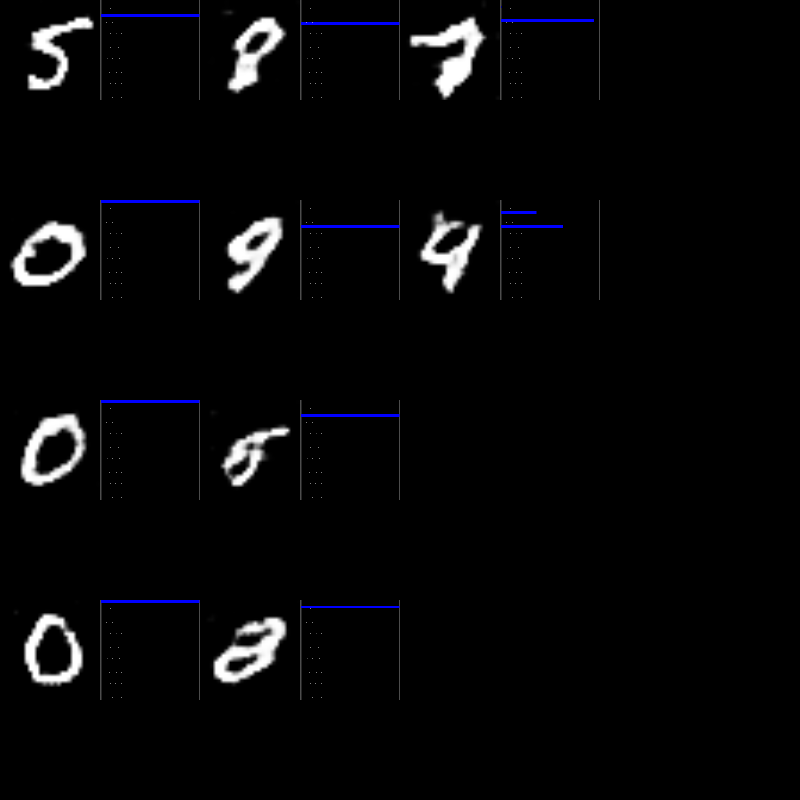

In [82]:
im = disp_grid_with_pred(X_sorted[0::1000], preds_sorted[0::1000], h=200)
imsave('imgs/out.png', im)
Image('imgs/out.png', width=800, height=800)